<a href="https://colab.research.google.com/github/fornitroll/Object-Detection-with-PyTorch-Kyiv-/blob/master/Lecture_6_Regional_Proposal_Networks_Mask_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 6. Regional Proposal Networks. Mask R-CNN
Hi friends, i know that last lecture was tough. Luckily Mask RCNN is basically small addition to the Faster RCNN (not vanilla of course). So this lecture will just focus on some small enchancements to add instance segmentation to our previous solution

What we will learn in this lecture:

* How to add few heads to the network
* What is the profit from multi-task learning

## Mask R-CNN
<img src="https://github.com/learnml-today/object-detection-with-pytorch/blob/master/imgs/mrcnn.jpg?raw=true">

**How model works:**

1.Extract region proposals</br>
2.For each proposed region run ROI Align for classifier and mask predictor</br>
3.1.For each each feature run classifier</br>
3.2.For each each feature run mask-detector</br>
4.For each box in the result choose appropriate class mask by predicted label</br>
5.Rescale masks to fit image (we got them with spatial size 28x28)</br>

Here I should mention one more thing. In most cases in multitask learning heads are sharing some same layers and in such way improve each other. But in the current solution of MaskRCCN, as the loss is not propagated through Region Proposal Network, the only shared layers are layers of the backbone model. So if we freeze backbone we will not get multi-task learning boost.





In [0]:
import time
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import sys

import cv2
import numpy as np
from collections import OrderedDict
import random
from collections import defaultdict
import math
from PIL import Image, ImageDraw, ImageFile
# fix bugs with loading png files
ImageFile.LOAD_TRUNCATED_IMAGES = True

import matplotlib.pyplot as plt
from matplotlib import cm

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torch.hub import load_state_dict_from_url
from torchvision.ops.boxes import batched_nms
from torchvision.ops import boxes as box_ops
from torchvision.ops import misc as misc_nn_ops



from google.colab import files
def upload(path):
    uploaded = files.upload()
    with open(path,'wb') as fp:
        fp.write(uploaded[list(uploaded.keys())[0]])
 
def download(path):
    files.download(path)

As torchvision for some reason divided Detection and Segmentation parts of the VOC dataset into two different classes, we should bring them together.

In [0]:
from torchvision.datasets.voc import download_extract
        
class VOCAll(datasets.VOCDetection):

    def __init__(self, *args,**kwargs):
        try:
            super(VOCAll, self).__init__(*args,**kwargs)
        except ConnectionResetError:
            kwargs['download'] = False
            url = 'http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar'
            md5 = '6cd6e144f989b92b3379bac3b3de84fd'
            filename = 'VOCtrainval_11-May-2012.tar'
            root = args[0]
            download_extract(url, root, filename, md5)
            super(VOCAll, self).__init__(*args,**kwargs)
        
        year = kwargs.get('year','2012')

        base_dir = datasets.voc.DATASET_YEAR_DICT[year]['base_dir']
        voc_root = os.path.join(self.root, base_dir)
        
        image_dir = os.path.join(voc_root, 'JPEGImages')
        mask_dir = os.path.join(voc_root, 'SegmentationObject')
        annotation_dir = os.path.join(voc_root, 'Annotations')

        splits_dir = os.path.join(voc_root, 'ImageSets/Segmentation')

        split_f = os.path.join(splits_dir, self.image_set.rstrip('\n') + '.txt')

        with open(os.path.join(split_f), "r") as f:
            file_names = [x.strip() for x in f.readlines()]

        self.images = [os.path.join(image_dir, x + ".jpg") for x in file_names]
        self.annotations = [os.path.join(annotation_dir, x + ".xml") for x in file_names]
        self.masks = [os.path.join(mask_dir, x + ".png") for x in file_names]
        assert (len(self.images) == len(self.masks))

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is the image segmentation.
        """
        img = Image.open(self.images[index]).convert('RGB')
        mask = np.array(Image.open(self.masks[index]).convert('RGB'))
        box = self.parse_voc_xml(
            datasets.voc.ET.parse(self.annotations[index]).getroot())

        colors = set(map(tuple,np.unique(mask.reshape(-1, mask.shape[2]), axis=0).tolist()))
        # removing background and edge mask
        colors = np.array(list(colors - set([(224,224,192),(0,0,0)])))
        # split the color-encoded mask into a set
        # of binary masks
        masks = []
        for color in colors:
            masks.append(cv2.inRange(mask, color, color))
        masks = np.array(masks,dtype=np.uint8)

        bbox_masks = []
        for i in range(masks.shape[0]):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            bbox_masks.append([xmin, ymin, xmax, ymax])

        target = {'annotation':box['annotation'],'mask':masks, 'bbox_masks':bbox_masks}

        if self.transforms is not None:
            img, target = self.transforms(img, target)


        return img, target



Adding masks to our VOC transformer. There is a small pitfall, our segmentation is an RGB image so we need to divide instances by color, and with IoU find out which boxes they correspond to.

In [0]:
class VOC2FRCNNTransform:     
        
    def __call__(self, img, target):
        classes = [
            "bg","person", "bird", "cat", "cow", "dog", "horse", "sheep",
            "aeroplane", "bicycle", "boat", "bus", "car", "motorbike", "train",
            "bottle", "chair", "diningtable", "pottedplant", "sofa", "tvmonitor"
        ] # bg+20 classes

        boxes = []
        labels = []
        w,h = img.size
        # voc bboxes annotation can be list if many or dict if one (never do like this)
        objects = target['annotation']['object'] if isinstance(target['annotation']['object'], list) else [target['annotation']['object']]
        for i, bb in enumerate(objects):
            b = bb['bndbox']
            b = [int(b['xmin']),int(b['ymin']),int(b['xmax']),int(b['ymax'])]
            boxes.append(b)
            labels.append(classes.index(bb['name']))

        # problem that our dataset doesnt have info about labels for instance segmentation
        # so we will use IoU to compare boxes with mask boxes to find out which labels 
        # set to segmented instances
        boxes = torch.tensor(boxes, dtype=torch.float32)
        mask_boxes = torch.tensor(target['bbox_masks'], dtype=torch.float32)
 
        quality = box_ops.box_iou(boxes, mask_boxes) # NxM
        # so what mask_box will get first box in boxes list
        res = quality.argmax(dim=1)
        # now re-set masks in correct order
        masks = []
        for i in res.tolist():
            masks.append(target['mask'][i])
        masks = np.array(masks)  

        t = transforms.ToTensor()
        return t(img), {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64),
            # normalize masks to [0,1]
            'masks': torch.tensor(masks/255, dtype=torch.float32)
        }

def test_dataloading(ds):
    def denorm(x):
        return np.ascontiguousarray((x*255).cpu().detach().numpy().transpose(1,2,0).astype(np.uint8))

    for i in range(10):
        _img, ts = ds[i]
        img = denorm(_img)
        alpha = 0.5

        mask = (ts['labels'] > 0)
        masks = ts['masks'].numpy().astype(np.uint8)
        res = ts['boxes'][mask].numpy()
        # img = cv2.addWeighted(masks, alpha, img, 1 - alpha, 0)
        global_mask = np.zeros(img.shape,dtype=np.uint8)
        step = int(255/len(res))
        for i,bb in enumerate(res):    
            img = cv2.rectangle(img, (int(bb[0]), int(bb[1])), (int(bb[2]), int(bb[3])), (255, 255, 255), 2)
            color = (np.array(cm.jet(i*step)[:3])*255).astype(np.uint8)
            m = np.repeat(masks[i][:,:,None], 3, axis=2) * color
            global_mask += m
        img = cv2.addWeighted(global_mask, 0.7, img, 1, 0)

        plt.imshow(img)
        plt.show()
        print('Shape:',img.shape,'Boxes:',len(ts['boxes']))

Testing as always)))

0it [00:00, ?it/s]

1999642624it [03:40, 9375498.53it/s]                                /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


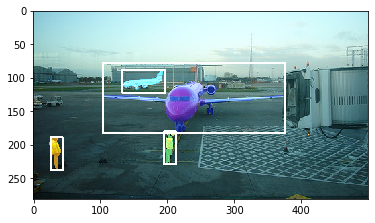

Shape: (281, 500, 3) Boxes: 4


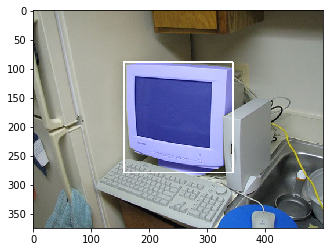

Shape: (375, 500, 3) Boxes: 1


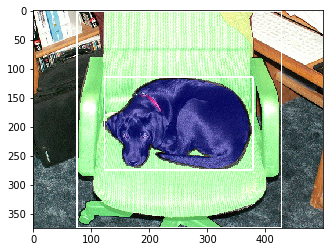

Shape: (375, 500, 3) Boxes: 2


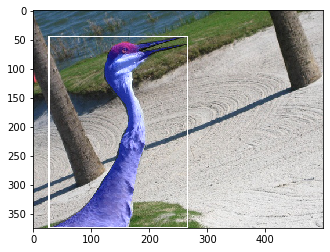

Shape: (375, 500, 3) Boxes: 1


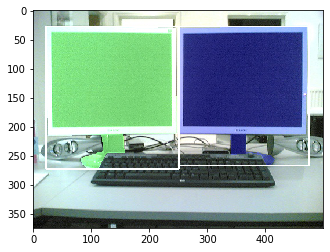

Shape: (375, 500, 3) Boxes: 2


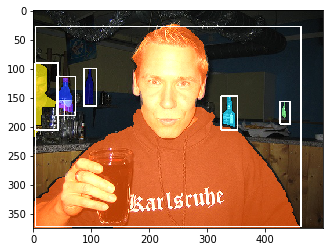

Shape: (375, 500, 3) Boxes: 6


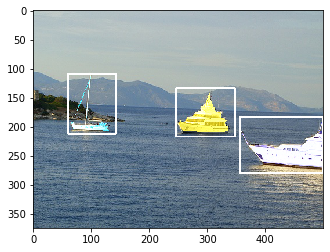

Shape: (375, 500, 3) Boxes: 3


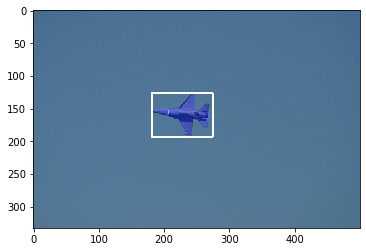

Shape: (333, 500, 3) Boxes: 1


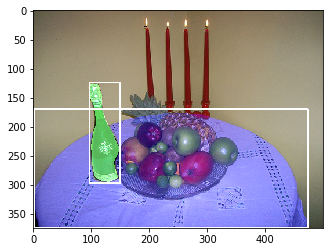

Shape: (375, 500, 3) Boxes: 2


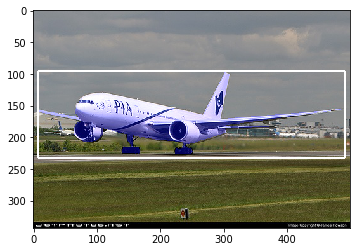

Shape: (343, 500, 3) Boxes: 1


In [0]:
dd = VOCAll('./voc', download=True, transforms=VOC2FRCNNTransform())
test_dataloading(dd)

We are using the function paste_masks_in_image on inference to resize our masks to the original image size

In [0]:
## New #####
def expand_boxes(boxes, scale):
    # resize boxes to new scale after mask size changed
    w_half = (boxes[:, 2] - boxes[:, 0]) * .5
    h_half = (boxes[:, 3] - boxes[:, 1]) * .5
    x_c = (boxes[:, 2] + boxes[:, 0]) * .5
    y_c = (boxes[:, 3] + boxes[:, 1]) * .5

    w_half *= scale
    h_half *= scale

    boxes_exp = torch.zeros_like(boxes)
    boxes_exp[:, 0] = x_c - w_half
    boxes_exp[:, 2] = x_c + w_half
    boxes_exp[:, 1] = y_c - h_half
    boxes_exp[:, 3] = y_c + h_half
    return boxes_exp

def expand_masks(mask, padding):
    # here we add some padding to the mask image
    M = mask.shape[-1]
    scale = float(M + 2 * padding) / M
    padded_mask = torch.nn.functional.pad(mask, (padding,) * 4)
    return padded_mask, scale

def paste_mask_in_image(mask, box, im_h, im_w):
    TO_REMOVE = 1
    w = int(box[2] - box[0] + TO_REMOVE)
    h = int(box[3] - box[1] + TO_REMOVE)
    w = max(w, 1)
    h = max(h, 1)

    # Set shape to [batchxCxHxW]
    mask = mask.expand((1, 1, -1, -1))

    # Resize mask
    mask = misc_nn_ops.interpolate(mask, size=(h, w), mode='bilinear', align_corners=False)
    mask = mask[0][0]

    # here we cutting mask in cases when our predicted box out of image shape
    im_mask = torch.zeros((im_h, im_w), dtype=mask.dtype, device=mask.device)
    x_0 = max(box[0], 0)
    x_1 = min(box[2] + 1, im_w)
    y_0 = max(box[1], 0)
    y_1 = min(box[3] + 1, im_h)

    im_mask[y_0:y_1, x_0:x_1] = mask[
        (y_0 - box[1]):(y_1 - box[1]), (x_0 - box[0]):(x_1 - box[0])
    ]
    return im_mask

def paste_masks_in_image(masks, boxes, img_shape, padding=1):
    # here we do some modification to improve interpolation results for mask
    # on edges.
    # as we dont want to get rough edge for masks we add some padding so on 
    # interpolation we get some smoothing 
    masks, scale = expand_masks(masks, padding=padding)
    # after we change the spatial size of masks we need to change the size of 
    # boxes to the new scale
    boxes = expand_boxes(boxes, scale).to(dtype=torch.int64)

    im_h, im_w = img_shape

    boxes = boxes.tolist()
    # here we just resizing our masks to fit image size
    res = [
        paste_mask_in_image(m[0], b, im_h, im_w)
        for m, b in zip(masks, boxes)
    ]
    if len(res) > 0:
        res = torch.stack(res, dim=0)[:, None]
    else:
        res = masks.new_empty((0, 1, im_h, im_w))
    return res
################

class ImageList(object):
    """
    Structure that holds a list of images (of possibly
    varying sizes) as a single tensor.
    This works by padding the images to the same size,
    and storing in a field the original sizes of each image
    """

    def __init__(self, tensors, image_sizes):
        """
        Arguments:
            tensors (tensor)
            image_sizes (list[tuple[int, int]])
        """
        self.tensors = tensors
        self.image_sizes = image_sizes

    def to(self, *args, **kwargs):
        cast_tensor = self.tensors.to(*args, **kwargs)
        return ImageList(cast_tensor, self.image_sizes)

class GeneralizedRCNNTransform(nn.Module):
    """
    Performs input / target transformation before feeding the data to a GeneralizedRCNN
    model.
    The transformations it perform are:
        - input normalization (mean subtraction and std division)
        - input / target resizing to match min_size / max_size
    It returns a ImageList for the inputs, and a List[Dict[Tensor]] for the targets
    """

    def __init__(self, min_size, max_size, image_mean, image_std):
        super(GeneralizedRCNNTransform, self).__init__()
        if not isinstance(min_size, (list, tuple)):
            min_size = (min_size,)
        self.min_size = min_size
        self.max_size = max_size
        self.image_mean = image_mean
        self.image_std = image_std

    def forward(self, images, targets=None):
        images = [img for img in images]
        for i in range(len(images)):
            image = images[i]
            target = targets[i] if targets is not None else targets
            if image.dim() != 3:
                raise ValueError("images is expected to be a list of 3d tensors "
                                 "of shape [C, H, W], got {}".format(image.shape))
            image = self.normalize(image)
            image, target = self.resize(image, target)
            images[i] = image
            if targets is not None:
                targets[i] = target

        image_sizes = [img.shape[-2:] for img in images]
        images = self.batch_images(images)
        image_list = ImageList(images, image_sizes)
        return image_list, targets

    def normalize(self, image):
        dtype, device = image.dtype, image.device
        mean = torch.as_tensor(self.image_mean, dtype=dtype, device=device)
        std = torch.as_tensor(self.image_std, dtype=dtype, device=device)
        return (image - mean[:, None, None]) / std[:, None, None]

    def resize(self, image, target):
        h, w = image.shape[-2:]
        im_shape = torch.tensor(image.shape[-2:])
        min_size = float(torch.min(im_shape))
        max_size = float(torch.max(im_shape))
        if self.training:
            size = random.choice(self.min_size)
        else:
            # FIXME assume for now that testing uses the largest scale
            size = self.min_size[-1]
        scale_factor = size / min_size
        if max_size * scale_factor > self.max_size:
            scale_factor = self.max_size / max_size

        # image[None] - adds additional dimension on start (10,10) -> (1,10,10)
        image = torch.nn.functional.interpolate(
            image[None], scale_factor=scale_factor, mode='bilinear', align_corners=False)[0]

        if target is None:
            return image, target

        bbox = target["boxes"]
        bbox = resize_boxes(bbox, (h, w), image.shape[-2:])
        target["boxes"] = bbox

        ## New
        if "masks" in target:
            mask = target["masks"]
            mask = misc_nn_ops.interpolate(mask[None].float(), scale_factor=scale_factor)[0].byte()
            target["masks"] = mask
        #######
        
        return image, target

    def batch_images(self, images, size_divisible=32):
        '''creating image batch based on max image size, and pad all other'''
        max_size = tuple(max(s) for s in zip(*[img.shape for img in images]))
        stride = size_divisible
        max_size = list(max_size)
        max_size[1] = int(math.ceil(float(max_size[1]) / stride) * stride)
        max_size[2] = int(math.ceil(float(max_size[2]) / stride) * stride)
        max_size = tuple(max_size)

        batch_shape = (len(images),) + max_size
        # creating zeros tensor of shape batch_shape of the same type and device as images tensor
        batched_imgs = images[0].new(*batch_shape).zero_()
        for img, pad_img in zip(images, batched_imgs):
            pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)

        return batched_imgs

    def postprocess(self, result, image_shapes, original_image_sizes):
        if self.training:
            return result
        for i, (pred, im_s, o_im_s) in enumerate(zip(result, image_shapes, original_image_sizes)):
            boxes = pred["boxes"]
            boxes = resize_boxes(boxes, im_s, o_im_s)
            result[i]["boxes"] = boxes
            ## New
            if "masks" in pred:
                masks = pred["masks"]
                masks = paste_masks_in_image(masks, boxes, o_im_s)
                result[i]["masks"] = masks
            #######
        return result

def resize_boxes(boxes, original_size, new_size):
    ratios = tuple(float(s) / float(s_orig) for s, s_orig in zip(new_size, original_size))
    ratio_height, ratio_width = ratios
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    xmin = xmin * ratio_width
    xmax = xmax * ratio_width
    ymin = ymin * ratio_height
    ymax = ymax * ratio_height
    return torch.stack((xmin, ymin, xmax, ymax), dim=1)

In [0]:
def test_GeneralizedRCNNTransform(ds):
    image_mean = [0.485, 0.456, 0.406]
    image_std = [0.229, 0.224, 0.225]
    transform = GeneralizedRCNNTransform(800, 1333, image_mean, image_std)  

    def denorm(x):
        x = np.ascontiguousarray((x).cpu().detach().numpy().transpose(1,2,0))
        x = (x * np.array(image_std)) + np.array(image_mean)
        return (x*255).astype(np.uint8)

    for i in range(4):
        img, ts = ds[i]
        images, ts = transform([img],[ts])
        img = denorm(images.tensors[0])
        ts = ts[0]

        mask = (ts['labels'] > 0)
        masks = ts['masks'].numpy().astype(np.uint8)
        res = ts['boxes'][mask].numpy()
        global_mask = np.zeros(img.shape,dtype=np.uint8)
        
        step = int(255/len(res))
        for i,bb in enumerate(res):    
            img = cv2.rectangle(img, (int(bb[0]), int(bb[1])), (int(bb[2]), int(bb[3])), (255, 255, 255), 2)
            color = (np.array(cm.jet(i*step)[:3])*255).astype(np.uint8)
            m = np.repeat(masks[i][:,:,None], 3, axis=2) * color
            c = m.shape
            global_mask[:c[0],:c[1],:] = m
        img = cv2.addWeighted(global_mask, 0.7, img, 1, 0)

        plt.imshow(img)
        plt.show()
        print('Shape:',img.shape,'Boxes:',len(ts['boxes']))

Testing is a good habbit in the ML

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


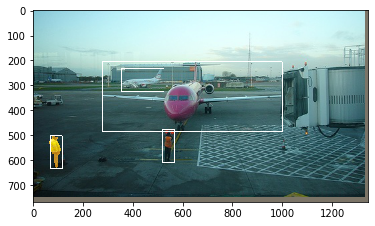

Shape: (768, 1344, 3) Boxes: 4


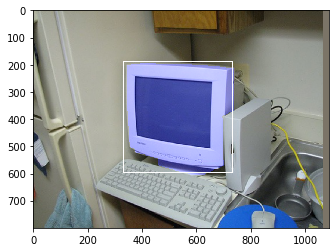

Shape: (800, 1088, 3) Boxes: 1


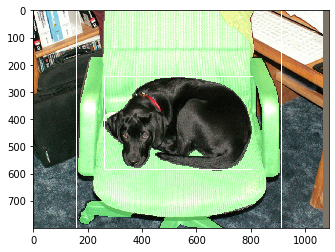

Shape: (800, 1088, 3) Boxes: 2


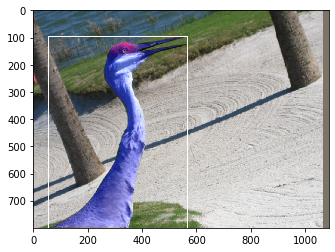

Shape: (800, 1088, 3) Boxes: 1


In [0]:
dd = VOCAll('./voc', download=False, transforms=VOC2FRCNNTransform())
test_GeneralizedRCNNTransform(dd)

## Backbone Model
Same as in Faster R-CNN

In [0]:

class FeaturePyramidNetwork(nn.Module):
    """
    Module that adds a FPN from on top of a set of feature maps. This is based on
    `"Feature Pyramid Network for Object Detection" <https://arxiv.org/abs/1612.03144>`.
    We using "Top-down pathway and lateral connections" method to construct the pyramid.
    The feature maps are currently supposed to be in increasing depth
    order.
    The input to the model is expected to be an OrderedDict[Tensor], containing
    the feature maps on top of which the FPN will be added.
    Arguments:
        in_channels_list (list[int]): number of channels for each feature map that
            is passed to the module
        out_channels (int): number of channels of the FPN representation
        extra_block (ExtraFPNBlock or None): if provided, extra operations will
            be performed. It is expected to take the fpn features, the original
            features and the names of the original features as input, and returns
            a new list of feature maps and their corresponding names
    Examples::
        >>> m = torchvision.ops.FeaturePyramidNetwork([10, 20, 30], 5)
        >>> # get some dummy data
        >>> x = OrderedDict()
        >>> x['feat0'] = torch.rand(1, 10, 64, 64)
        >>> x['feat2'] = torch.rand(1, 20, 16, 16)
        >>> x['feat3'] = torch.rand(1, 30, 8, 8)
        >>> # compute the FPN on top of x
        >>> output = m(x)
        >>> print([(k, v.shape) for k, v in output.items()])
        >>> # returns
        >>>   [('feat0', torch.Size([1, 5, 64, 64])),
        >>>    ('feat2', torch.Size([1, 5, 16, 16])),
        >>>    ('feat3', torch.Size([1, 5, 8, 8]))]
    """

    def __init__(self, in_channels_list, out_channels, extra_blocks=None):
        super(FeaturePyramidNetwork, self).__init__()
        self.inner_blocks = nn.ModuleList()
        self.layer_blocks = nn.ModuleList()
        for in_channels in in_channels_list:
            if in_channels == 0:
                continue
            inner_block_module = nn.Conv2d(in_channels, out_channels, 1)
            layer_block_module = nn.Conv2d(out_channels, out_channels, 3, padding=1)
            self.inner_blocks.append(inner_block_module)
            self.layer_blocks.append(layer_block_module)

        # initialize parameters now to avoid modifying the initialization of top_blocks
        for m in self.children():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, a=1)
                nn.init.constant_(m.bias, 0)

        self.extra_block = extra_blocks

    def forward(self, x):
        """
        Computes the FPN for a set of feature maps.
        Arguments:
            x (OrderedDict[Tensor]): feature maps for each feature level.
        Returns:
            results (OrderedDict[Tensor]): feature maps after FPN layers.
                They are ordered from highest resolution first.
        """
        # unpack OrderedDict into two lists for easier handling
        names = list(x.keys())
        x = list(x.values())

        last_inner = self.inner_blocks[-1](x[-1])
        results = []
        results.append(self.layer_blocks[-1](last_inner))
        for feature, inner_block, layer_block in zip(
            x[:-1][::-1], self.inner_blocks[:-1][::-1], self.layer_blocks[:-1][::-1]
        ):
            if not inner_block:
                continue
            inner_lateral = inner_block(feature)
            feat_shape = inner_lateral.shape[-2:]
            inner_top_down = F.interpolate(last_inner, size=feat_shape, mode="nearest")
            last_inner = inner_lateral + inner_top_down
            results.insert(0, layer_block(last_inner))

        if self.extra_block is not None:
            results, names = self.extra_block(results, x, names)

        # make it back an OrderedDict
        out = OrderedDict([(k, v) for k, v in zip(names, results)])

        return out

class LastLevelMaxPool(nn.Module):
    """
    Applies a max_pool2d on top of the last feature map
    It used to add feature which cover whole image (really big bbox)
    """
    def forward(self, x, y, names):
        names.append("pool")
        x.append(F.max_pool2d(x[-1], 1, 2, 0))
        return x, names

In [0]:

class Slicer(nn.Module):
    def __init__(self, model, outputs):
        super(Slicer, self).__init__()
        self.outputs = outputs

        layers = OrderedDict()
        t = outputs[:]
        for name, module in model.named_children():
            layers[name] = module
            if name in t:
                t.remove(name)
            if not t:
                break
        self.layers = nn.ModuleDict(layers)

    def forward(self, x):
        out = OrderedDict()
        for name, module in self.layers.items():
            x = module(x)
            if name in self.outputs:
                out[name] = x
        return out

class ResNet50FPNBackbone(nn.Sequential):

    def __init__(self, freeze=True, use_last_max_pool=True,out_channels=256):
        super(ResNet50FPNBackbone, self).__init__()

        self.out_channels = out_channels
        # layers output of which we need for our pyramid network
        out = ['layer1','layer2','layer3','layer4']
        # we use norm_layer=misc_nn_ops.FrozenBatchNorm2d to fix BatchNorm weights while optimizing weights of resnet
        # this is done because BatchNorm weights are small and can be killed by gradient on a start of the learning
        backbone = models.resnet50(pretrained=True, norm_layer=misc_nn_ops.FrozenBatchNorm2d)
        if not freeze:
            # we freeze layer 1 as it contains distribution of low-level features that same among our datasets
            for name, parameter in backbone.named_parameters():
                if 'layer2' not in name and 'layer3' not in name and 'layer4' not in name:
                    parameter.requires_grad_(False)
        else:
            backbone.requires_grad_(False)

        body = Slicer(backbone, out)
        extra_block = None
        # this will add additional layer to detecting much bigger object. 
        # Not always needed
        if use_last_max_pool:
            extra_block = LastLevelMaxPool()
        fpn = FeaturePyramidNetwork(in_channels_list=[256,512,1024,2048],out_channels=out_channels, extra_blocks=extra_block)
        super(ResNet50FPNBackbone, self).__init__(OrderedDict(
            [("body", body), ("fpn", fpn)]))


In [0]:
class AnchorGenerator(nn.Module):
    """
    Module that generates anchors for a set of feature maps and
    image sizes.
    The module support computing anchors at multiple sizes and aspect ratios
    per feature map.
    sizes and aspect_ratios should have the same number of elements, and it should
    correspond to the number of feature maps.
    sizes[i] and aspect_ratios[i] can have an arbitrary number of elements,
    and AnchorGenerator will output a set of sizes[i] * aspect_ratios[i] anchors
    per spatial location for feature map i.
    Arguments:
        sizes (Tuple[Tuple[int]]):
        aspect_ratios (Tuple[Tuple[float]]):
    """

    def __init__(
        self,
        sizes=((128,), (256,), (512,)),
        aspect_ratios=((0.5, 1.0, 2.0),(0.5, 1.0, 2.0),(0.5, 1.0, 2.0))
    ):
        super(AnchorGenerator, self).__init__()

        if not isinstance(sizes[0], (list, tuple)):
            sizes = tuple((s,) for s in sizes)
        if not isinstance(aspect_ratios[0], (list, tuple)):
            aspect_ratios = (aspect_ratios,) * len(sizes)

        assert len(sizes) == len(aspect_ratios)

        self.sizes = sizes
        self.aspect_ratios = aspect_ratios
        self.cell_anchors = None
        self._cache = {}

    @staticmethod
    def generate_anchors(scales, aspect_ratios, dtype=torch.float32, device="cpu"):
        '''Here we do th same as in SSD Default Boxes, except scales not 
        calculated by formula but set directly'''
        scales = torch.as_tensor(scales, dtype=dtype, device=device)
        aspect_ratios = torch.as_tensor(aspect_ratios, dtype=dtype, device=device)
        h_ratios = torch.sqrt(aspect_ratios)
        w_ratios = 1 / h_ratios

        ws = (w_ratios[:, None] * scales[None, :]).view(-1)
        hs = (h_ratios[:, None] * scales[None, :]).view(-1)

        base_anchors = torch.stack([-ws, -hs, ws, hs], dim=1) / 2
        return base_anchors.round()

    def set_cell_anchors(self, dtype, device):
        ''' Generating default anchors for a cell per feature map
            One cell has N anchors where N = M_sizes[i] * K_aspect_ratios[i]
        '''
        if self.cell_anchors is not None:
            return self.cell_anchors
        self.cell_anchors = [
            self.generate_anchors(
                sizes,
                aspect_ratios,
                dtype,
                device
            )
            for sizes, aspect_ratios in zip(self.sizes, self.aspect_ratios)
        ]

    def num_anchors_per_location(self):
        return [len(s) * len(a) for s, a in zip(self.sizes, self.aspect_ratios)]

    def grid_anchors(self, grid_sizes, strides):
        '''For each cell per feature we create default anchors by shifting base 
        blocks by cell left top coordinates'''
        anchors = []
        for size, stride, base_anchors in zip(
            grid_sizes, strides, self.cell_anchors
        ):
            grid_height, grid_width = size
            stride_height, stride_width = stride
            device = base_anchors.device
            shifts_x = torch.arange(
                0, grid_width, dtype=torch.float32, device=device
            ) * stride_width
            shifts_y = torch.arange(
                0, grid_height, dtype=torch.float32, device=device
            ) * stride_height
            shift_y, shift_x = torch.meshgrid(shifts_y, shifts_x)

            shift_x = shift_x.reshape(-1)
            shift_y = shift_y.reshape(-1)
            shifts = torch.stack((shift_x, shift_y, shift_x, shift_y), dim=1)

            anchors.append(
                (shifts.view(-1, 1, 4) + base_anchors.view(1, -1, 4)).reshape(-1, 4)
            )
        return anchors

    def cached_grid_anchors(self, grid_sizes, strides):
        '''Use cache to not recalculate anchors for same sizes'''
        key = tuple(grid_sizes) + tuple(strides)
        if key in self._cache:
            return self._cache[key]
        anchors = self.grid_anchors(grid_sizes, strides)
        self._cache[key] = anchors
        return anchors

    def forward(self, image_list, feature_maps, debug=False):
        ''' Creating list of default boxes per image feature.
            We use dynamic boxes and not precalculated because our input images 
            have dynamic shapes. 
            Also we are not doing any normalization here.
        '''
        grid_sizes = tuple([feature_map.shape[-2:] for feature_map in feature_maps])
        image_size = image_list.tensors.shape[-2:]
        strides = tuple((image_size[0] / g[0], image_size[1] / g[1]) for g in grid_sizes)
        dtype, device = feature_maps[0].dtype, feature_maps[0].device
        self.set_cell_anchors(dtype, device)
        anchors_over_all_feature_maps = self.cached_grid_anchors(grid_sizes, strides)
        anchors = []
        if debug:
            print('DEBUG ANCHORBOX')
            return anchors_over_all_feature_maps
        # concatenate all boxes per feature to get boxes per image
        for i in range(len(image_list.image_sizes)):
            anchors_in_image = []
            for anchors_per_feature_map in anchors_over_all_feature_maps:
                anchors_in_image.append(anchors_per_feature_map)
            anchors.append(anchors_in_image)
        anchors = [torch.cat(anchors_per_image) for anchors_per_image in anchors]
        return anchors


## Region Proposal Network
Same as in Faster R-CNN

In [0]:
class RPNHead(nn.Module):
    """
    Adds a simple RPN Head with classification and regression heads
    Arguments:
        in_channels (int): number of channels of the input feature
        num_anchors (int): number of anchors to be predicted
    """

    def __init__(self, in_channels, num_anchors=3):
        super(RPNHead, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, in_channels, kernel_size=3, stride=1, padding=1
        )
        self.cls_logits = nn.Conv2d(in_channels, num_anchors, kernel_size=1, stride=1)
        self.bbox_pred = nn.Conv2d(
            in_channels, num_anchors * 4, kernel_size=1, stride=1
        )

        for l in self.children():
            # as in paper
            torch.nn.init.normal_(l.weight, std=0.01)
            torch.nn.init.constant_(l.bias, 0)

    def forward(self, x):
        logits = []
        bbox_reg = []
        for feature in x:
            t = F.relu(self.conv(feature))
            logits.append(self.cls_logits(t))
            bbox_reg.append(self.bbox_pred(t))
        return logits, bbox_reg

In [0]:

def permute_and_flatten(layer, N, C, H, W):
    layer = layer.view(N, -1, C, H, W) # N,A,C,H,W
    layer = layer.permute(0, 3, 4, 1, 2) # N,H,W,A,C
    layer = layer.reshape(N, -1, C) # N,HxWxA,C
    return layer


def concat_box_prediction_layers(box_cls, box_regression):
    box_cls_flattened = []
    box_regression_flattened = []
    # for each feature level, permute the outputs to make them be in the
    # same format as the labels. Note that the labels are computed for
    # all feature levels concatenated, so we keep the same representation
    # for the objectness and the box_regression
    for box_cls_per_level, box_regression_per_level in zip(
        box_cls, box_regression
    ):
        N, AxC, H, W = box_cls_per_level.shape
        Ax4 = box_regression_per_level.shape[1]
        A = Ax4 // 4
        C = AxC // A
        box_cls_per_level = permute_and_flatten(
            box_cls_per_level, N, C, H, W
        ) # N, HxWxA, C
        box_cls_flattened.append(box_cls_per_level)

        box_regression_per_level = permute_and_flatten(
            box_regression_per_level, N, 4, H, W
        ) # N, HxWxA, 4
        box_regression_flattened.append(box_regression_per_level)

    # getting box_cls and box_reg per batch
    # concatenate on the first dimension (representing the feature levels), to
    # take into account the way the labels were generated (with all feature maps
    # being concatenated as well)
    box_cls = torch.cat(box_cls_flattened, dim=1).reshape(-1, C)
    box_regression = torch.cat(box_regression_flattened, dim=1).reshape(-1, 4)
    return box_cls, box_regression


class RegionProposalNetwork(torch.nn.Module):
    """
    Implements Region Proposal Network (RPN).
    Arguments:
        anchor_generator (AnchorGenerator): module that generates the anchors for a set of feature
            maps.
        head (nn.Module): module that computes the objectness and regression deltas
        fg_iou_thresh (float): minimum IoU between the anchor and the GT box so that they can be
            considered as positive during training of the RPN.
        bg_iou_thresh (float): maximum IoU between the anchor and the GT box so that they can be
            considered as negative during training of the RPN.
        batch_size_per_image (int): number of anchors that are sampled during training of the RPN
            for computing the loss
        positive_fraction (float): proportion of positive anchors in a mini-batch during training
            of the RPN
        pre_nms_top_n (Dict[int]): number of proposals to keep before applying NMS. It should
            contain two fields: training and testing, to allow for different values depending
            on training or evaluation
        post_nms_top_n (Dict[int]): number of proposals to keep after applying NMS. It should
            contain two fields: training and testing, to allow for different values depending
            on training or evaluation
        nms_thresh (float): NMS threshold used for postprocessing the RPN proposals

    Return: Not normalized ROIs
    """

    def __init__(self,
                 anchor_generator,
                 head,
                 #
                 fg_iou_thresh, bg_iou_thresh,
                 batch_size_per_image, positive_fraction,
                 #
                 pre_nms_top_n, post_nms_top_n, nms_thresh):
        super(RegionProposalNetwork, self).__init__()
        self.anchor_generator = anchor_generator
        self.head = head
        self.box_coder = BoxCoder(weights=(1.0, 1.0, 1.0, 1.0))

        # used during training
        self.box_similarity = box_ops.box_iou

        self.proposal_matcher = Matcher(
            fg_iou_thresh,
            bg_iou_thresh,
            allow_low_quality_matches=True,
        )
        self.fg_bg_sampler = BalancedPositiveNegativeSampler(
            batch_size_per_image, positive_fraction
        )
        self.batch_size_per_image = batch_size_per_image
        # used during testing
        self._pre_nms_top_n = pre_nms_top_n # 2000
        self._post_nms_top_n = post_nms_top_n # 1000
        self.nms_thresh = nms_thresh
        self.min_size = 1e-3

    @property
    def pre_nms_top_n(self):
        if self.training:
            return self._pre_nms_top_n['training']
        return self._pre_nms_top_n['testing']

    @property
    def post_nms_top_n(self):
        if self.training:
            return self._post_nms_top_n['training']
        return self._post_nms_top_n['testing']

    def forward(self, images, features, targets=None):
        """
        Arguments:
            images (ImageList): images for which we want to compute the predictions
            features (List[Tensor]): features computed from the images that are
                used for computing the predictions. Each tensor in the list
                correspond to different feature levels
            targets (List[Dict[Tensor]]): ground-truth boxes present in the image (optional).
                If provided, each element in the dict should contain a field `boxes`,
                with the locations of the ground-truth boxes.
        Returns:
            boxes (List[Tensor]): the predicted boxes from the RPN, one Tensor per
                image.
            losses (Dict[Tensor]): the losses for the model during training. During
                testing, it is an empty dict.
        """
        # RPN uses all feature maps that are available
        features = list(features.values())
        # getting proposal data
        objectness, pred_bbox_deltas = self.head(features)
        # getting anchor boxes for features
        anchors = self.anchor_generator(images, features)

        num_images = len(anchors)
        # numel() = total number of elements in tensor aka N*C*H*W
        num_anchors_per_feature_level = [o[0].numel() for o in objectness]
        # Per batch (-1, 1) and (-1, 4)
        objectness, pred_bbox_deltas = \
            concat_box_prediction_layers(objectness, pred_bbox_deltas)
        # apply pred_bbox_deltas to anchors to obtain the decoded proposals
        # note that we detach the deltas because Faster R-CNN do not backprop through
        # the proposals
        proposals = self.box_coder.decode(pred_bbox_deltas.detach(), anchors)
        proposals = proposals.view(num_images, -1, 4)
        # minimize number of proposals
        boxes, scores = self.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_feature_level)

        # Callculate RPN loss for training phase
        losses = {}
        if self.training:
            labels, matched_gt_boxes = self.assign_targets_to_anchors(anchors, targets)
            # transform gt_targets to the normalized and delta values as in RPNHead output
            regression_targets = self.box_coder.encode(matched_gt_boxes, anchors)
            loss_objectness, loss_rpn_box_reg = self.compute_loss(
                objectness, pred_bbox_deltas, labels, regression_targets)
            losses = {
                "loss_objectness": loss_objectness,
                "loss_rpn_box_reg": loss_rpn_box_reg,
            }

        return boxes, scores, losses

    def assign_targets_to_anchors(self, anchors, targets):
        ''' To compute loss of RPN we need to match targets with anchors, 
            in the same way as we did with SSD network
        '''
        labels = []
        matched_gt_boxes = []
        for anchors_per_image, targets_per_image in zip(anchors, targets):
            gt_boxes = targets_per_image["boxes"]
            # getting IoU of gt_boxes with anchor_boxes
            match_quality_matrix = self.box_similarity(gt_boxes, anchors_per_image)
            # run matcher to get ids of achor boxes matched with gt_boxes
            # Matcher strategy will be described below
            matched_idxs = self.proposal_matcher(match_quality_matrix)
            # matched_idxs = [k_1,k_2,k_1,k_3..] where k_i index of gt_box
            # get the targets corresponding GT for each proposal
            # NB: need to clamp the indices because we can have a single
            # GT in the image, and matched_idxs can be -2, which goes
            # out of bounds
            matched_gt_boxes_per_image = gt_boxes[matched_idxs.clamp(min=0)]

            # Foreground (positive examples). Set 1 for each object
            labels_per_image = matched_idxs >= 0
            labels_per_image = labels_per_image.to(dtype=torch.float32)

            # Background (negative examples). Set 0 for each background
            bg_indices = matched_idxs == self.proposal_matcher.BELOW_LOW_THRESHOLD
            labels_per_image[bg_indices] = 0

            # discard indices that are between thresholds
            inds_to_discard = matched_idxs == self.proposal_matcher.BETWEEN_THRESHOLDS
            labels_per_image[inds_to_discard] = -1

            labels.append(labels_per_image)
            matched_gt_boxes.append(matched_gt_boxes_per_image)
        return labels, matched_gt_boxes

    def compute_loss(self, objectness, pred_bbox_deltas, labels, regression_targets):
        """
        Arguments:
            objectness (Tensor)
            pred_bbox_deltas (Tensor)
            labels (List[Tensor])
            regression_targets (List[Tensor])
        Returns:
            objectness_loss (Tensor)
            box_loss (Tensor)
        """
        # by default we sample 128 positive and 128 negative examples
        # if positive not enought then we add more negative so the mini-batch has 
        # 256 examples
        sampled_pos_inds, sampled_neg_inds = self.fg_bg_sampler(labels)
        sampled_pos_inds = torch.nonzero(torch.cat(sampled_pos_inds, dim=0)).squeeze(1)
        sampled_neg_inds = torch.nonzero(torch.cat(sampled_neg_inds, dim=0)).squeeze(1)
        # FIX:
        # sampled_neg_inds = sampled_neg_inds[:sampled_pos_inds.shape[0]*3] # not more then 3x positives
        sampled_inds = torch.cat([sampled_pos_inds, sampled_neg_inds], dim=0)

        objectness = objectness.flatten()
        
        labels = torch.cat(labels, dim=0)
        regression_targets = torch.cat(regression_targets, dim=0)

        # calculate regression loss only for positive examples
        box_loss = F.smooth_l1_loss(
            pred_bbox_deltas[sampled_pos_inds],
            regression_targets[sampled_pos_inds],
            reduction="sum",
        ) / sampled_inds.numel() # (self.batch_size_per_image * batch)

        # labels calculated both for negative and positive examples
        objectness_loss = F.binary_cross_entropy_with_logits(
            objectness[sampled_inds], labels[sampled_inds]
        )

        return objectness_loss, box_loss

    def filter_proposals(self, proposals, objectness, image_shapes, num_anchors_per_level):
        ''' Filter out proposals

            How we do this:
            - Getting top N boxes by objectness (by default < 2000 per feature)
            - Remove small boxes with side less then 1e-3
            - Run NMS and remove intersecting boxes
            - Keep only K boxes after NMS (by default < 1000 per feature)

            By adding/removing contrains here we can change accuracy and speed of the network.
            For example:
            - For detecting vector graphics objects we can lover N,K boxes, 
            as we have less segments in image then in bitmap image.
            - For detecting objects of known size/shape we can add additional restriction
        '''
        num_images = proposals.shape[0]
        device = proposals.device
        # do not backprop throught objectness
        objectness = objectness.detach()
        assert not torch.isnan(torch.max(objectness)), 'Please lower Learning Rate'
        objectness = objectness.reshape(num_images, -1)

        levels = [
            # torch.full - create & fill matrix with value(idx)
            torch.full((n,), idx, dtype=torch.int64, device=device)
            for idx, n in enumerate(num_anchors_per_level)
        ] # = [[0,0,0,...],[1,1,1...],[2,2,2,..],..]
        levels = torch.cat(levels, 0) # = [0,0,0,...,1,1,1...,2,2,2,..]
        levels = levels.reshape(1, -1).expand_as(objectness) # copy the same per image in batch

        # select top_n boxes independently per level before applying nms
        top_n_idx = self._get_top_n_idx(objectness, num_anchors_per_level) # (num_images, K)
        batch_idx = torch.arange(num_images, device=device)[:, None] # (num_images,1)
        objectness = objectness[batch_idx, top_n_idx] # (num_images, K)
        levels = levels[batch_idx, top_n_idx] # (num_images, K)
        proposals = proposals[batch_idx, top_n_idx] # (num_images, K)

        final_boxes = []
        final_scores = []
        for boxes, scores, lvl, img_shape in zip(proposals, objectness, levels, image_shapes):
            # Clip boxes so that they lay inside an image of size `img_shape`.
            boxes = box_ops.clip_boxes_to_image(boxes, img_shape)
            # Remove boxes which contains at least one side smaller than self.min_size (1e-3)
            keep = box_ops.remove_small_boxes(boxes, self.min_size)
            boxes, scores, lvl = boxes[keep], scores[keep], lvl[keep]
            # running non-maximum suppression, independently done per level
            # to remove intersecting boxes
            keep = box_ops.batched_nms(boxes, scores, lvl, self.nms_thresh)
            # keep only topk scoring predictions (1000)
            keep = keep[:self.post_nms_top_n]
            boxes, scores = boxes[keep], scores[keep]
            final_boxes.append(boxes)
            final_scores.append(scores)
        return final_boxes, final_scores

    

    def _get_top_n_idx(self, objectness, num_anchors_per_level):
        r = []
        offset = 0
        for ob in objectness.split(num_anchors_per_level, 1):
            num_anchors = ob.shape[1]
            pre_nms_top_n = min(self.pre_nms_top_n, num_anchors)
            _, top_n_idx = ob.topk(pre_nms_top_n, dim=1)
            # as we have N features, we need add offsset
            r.append(top_n_idx + offset)
            offset += num_anchors
        return torch.cat(r, dim=1)



In [0]:
class Matcher(object):
    """
    This class assigns to each predicted "element" (e.g., a box) a ground-truth
    element. Each predicted element will have exactly zero or one matches; each
    ground-truth element may be assigned to zero or more predicted elements.
    Matching is based on the MxN match_quality_matrix, that characterizes how well
    each (ground-truth, predicted)-pair match. For example, if the elements are
    boxes, the matrix may contain box IoU overlap values.
    The matcher returns a tensor of size N containing the index of the ground-truth
    element m that matches to prediction n. If there is no match, a negative value
    is returned.
    """

    BELOW_LOW_THRESHOLD = -1
    BETWEEN_THRESHOLDS = -2

    def __init__(self, high_threshold, low_threshold, allow_low_quality_matches=False):
        """
        Args:
            high_threshold (float): quality values greater than or equal to
                this value are candidate matches.
            low_threshold (float): a lower quality threshold used to stratify
                matches into three levels:
                1) matches >= high_threshold
                2) BETWEEN_THRESHOLDS matches in [low_threshold, high_threshold)
                3) BELOW_LOW_THRESHOLD matches in [0, low_threshold)
            allow_low_quality_matches (bool): if True, produce additional matches
                for predictions that have only low-quality match candidates. See
                set_low_quality_matches_ for more details.
        """
        assert low_threshold <= high_threshold
        self.high_threshold = high_threshold
        self.low_threshold = low_threshold
        self.allow_low_quality_matches = allow_low_quality_matches

    def __call__(self, match_quality_matrix):
        """
        Args:
            match_quality_matrix (Tensor[float]): an MxN tensor, containing the
            pairwise quality between M ground-truth elements and N predicted elements.
        Returns:
            matches (Tensor[int64]): an N tensor where N[i] is a matched gt in
            [0, M - 1] or a negative value indicating that prediction i could not
            be matched.
        """
        if match_quality_matrix.numel() == 0:
            # empty targets or proposals not supported during training
            if match_quality_matrix.shape[0] == 0:
                raise ValueError(
                    "No ground-truth boxes available for one of the images "
                    "during training")
            else:
                raise ValueError(
                    "No proposal boxes available for one of the images "
                    "during training")

        # match_quality_matrix is M (gt) x N (predicted)
        # Max over gt elements (dim 0) to find best gt candidate for each prediction
        matched_vals, matches = match_quality_matrix.max(dim=0)
        if self.allow_low_quality_matches:
            all_matches = matches.clone()

        # Assign candidate matches with low quality to negative (unassigned) values
        below_low_threshold = matched_vals < self.low_threshold
        between_thresholds = (matched_vals >= self.low_threshold) & (
            matched_vals < self.high_threshold
        )
        matches[below_low_threshold] = Matcher.BELOW_LOW_THRESHOLD
        matches[between_thresholds] = Matcher.BETWEEN_THRESHOLDS

        if self.allow_low_quality_matches:
            self.set_low_quality_matches_(matches, all_matches, match_quality_matrix)

        return matches

    def set_low_quality_matches_(self, matches, all_matches, match_quality_matrix):
        """
        Produce additional matches for predictions that have only low-quality matches.
        Specifically, for each ground-truth find the set of predictions that have
        maximum overlap with it (including ties); for each prediction in that set, if
        it is unmatched, then match it to the ground-truth with which it has the highest
        quality value.
        """
        # For each gt, find the prediction with which it has highest quality
        highest_quality_foreach_gt, _ = match_quality_matrix.max(dim=1)
        # Find highest quality match available, even if it is low, including ties
        gt_pred_pairs_of_highest_quality = torch.nonzero(
            match_quality_matrix == highest_quality_foreach_gt[:, None]
        )
        # Example gt_pred_pairs_of_highest_quality:
        #   tensor([[    0, 39796],
        #           [    1, 32055],
        #           [    1, 32070],
        #           [    2, 39190],
        #           [    2, 40255],
        #           [    3, 40390],
        #           [    3, 41455],
        #           [    4, 45470],
        #           [    5, 45325],
        #           [    5, 46390]])
        # Each row is a (gt index, prediction index)
        # Note how gt items 1, 2, 3, and 5 each have two ties

        pred_inds_to_update = gt_pred_pairs_of_highest_quality[:, 1]
        matches[pred_inds_to_update] = all_matches[pred_inds_to_update]

In [0]:
class BalancedPositiveNegativeSampler(object):
    """
    This class samples batches, ensuring that they contain a fixed proportion 
    of positives. We will use it for loss calculation to fix influence of 
    negative examples (which are >>> positive ones)
    """

    def __init__(self, batch_size_per_image=256, positive_fraction=0.5):
        """
        Arguments:
            batch_size_per_image (int): number of elements to be selected per image
            positive_fraction (float): percentace of positive elements per batch
        """
        self.batch_size_per_image = batch_size_per_image
        self.positive_fraction = positive_fraction

    def __call__(self, matched_idxs):
        """
        Arguments:
            matched idxs: list of tensors containing -1, 0 or positive values.
                Each tensor corresponds to a specific image.
                -1 values are ignored, 0 are considered as negatives and > 0 as
                positives.
        Returns:
            pos_idx (list[tensor])
            neg_idx (list[tensor])
        Returns two lists of binary masks for each image.
        The first list contains the positive elements that were selected,
        and the second list the negative example.
        """
        pos_idx = []
        neg_idx = []
        for matched_idxs_per_image in matched_idxs:
            positive = torch.nonzero(matched_idxs_per_image >= 1).squeeze(1) # idx of positive labels
            negative = torch.nonzero(matched_idxs_per_image == 0).squeeze(1) # idx negative(bg) labels

            num_pos = int(self.batch_size_per_image * self.positive_fraction)
            # protect against not enough positive examples
            num_pos = min(positive.numel(), num_pos)
            num_neg = self.batch_size_per_image - num_pos
            # protect against not enough negative examples
            num_neg = min(negative.numel(), num_neg)

            # randomly select positive and negative examples
            perm1 = torch.randperm(positive.numel(), device=positive.device)[:num_pos] # random( [0,positive.numel()) )
            perm2 = torch.randperm(negative.numel(), device=negative.device)[:num_neg]
            pos_idx_per_image = positive[perm1] # random idx of positive labels with number less then num_pos
            neg_idx_per_image = negative[perm2]

            # create binary mask from indices
            pos_idx_per_image_mask = torch.zeros_like(
                matched_idxs_per_image, dtype=torch.uint8
            )
            neg_idx_per_image_mask = torch.zeros_like(
                matched_idxs_per_image, dtype=torch.uint8
            )
            pos_idx_per_image_mask[pos_idx_per_image] = 1
            neg_idx_per_image_mask[neg_idx_per_image] = 1

            pos_idx.append(pos_idx_per_image_mask)
            neg_idx.append(neg_idx_per_image_mask)

        return pos_idx, neg_idx

In [0]:


def encode_boxes(reference_boxes, proposals, weights):
    # type: (torch.Tensor, torch.Tensor, torch.Tensor) -> torch.Tensor
    """
    Encode a set of proposals with respect to some
    reference boxes
    Arguments:
        reference_boxes (Tensor): reference boxes
        proposals (Tensor): boxes to be encoded
    """

    # perform some unpacking to make it JIT-fusion friendly
    wx = weights[0]
    wy = weights[1]
    ww = weights[2]
    wh = weights[3]

    proposals_x1 = proposals[:, 0].unsqueeze(1)
    proposals_y1 = proposals[:, 1].unsqueeze(1)
    proposals_x2 = proposals[:, 2].unsqueeze(1)
    proposals_y2 = proposals[:, 3].unsqueeze(1)

    reference_boxes_x1 = reference_boxes[:, 0].unsqueeze(1)
    reference_boxes_y1 = reference_boxes[:, 1].unsqueeze(1)
    reference_boxes_x2 = reference_boxes[:, 2].unsqueeze(1)
    reference_boxes_y2 = reference_boxes[:, 3].unsqueeze(1)

    # implementation starts here
    ex_widths = proposals_x2 - proposals_x1
    ex_heights = proposals_y2 - proposals_y1
    ex_ctr_x = proposals_x1 + 0.5 * ex_widths
    ex_ctr_y = proposals_y1 + 0.5 * ex_heights

    gt_widths = reference_boxes_x2 - reference_boxes_x1
    gt_heights = reference_boxes_y2 - reference_boxes_y1
    gt_ctr_x = reference_boxes_x1 + 0.5 * gt_widths
    gt_ctr_y = reference_boxes_y1 + 0.5 * gt_heights

    # do normalization with weighing
    targets_dx = wx * (gt_ctr_x - ex_ctr_x) / ex_widths
    targets_dy = wy * (gt_ctr_y - ex_ctr_y) / ex_heights
    targets_dw = ww * torch.log(gt_widths / ex_widths)
    targets_dh = wh * torch.log(gt_heights / ex_heights)

    targets = torch.cat((targets_dx, targets_dy, targets_dw, targets_dh), dim=1)
    return targets


class BoxCoder(object):
    """
    This class encodes and decodes a set of bounding boxes into
    the representation used for training the regressors.
    """

    def __init__(self, weights, bbox_xform_clip=math.log(1000. / 16)):
        """
        Arguments:
            weights (4-element tuple)
            bbox_xform_clip (float)
        """
        self.weights = weights
        self.bbox_xform_clip = bbox_xform_clip

    def encode(self, reference_boxes, proposals):
        boxes_per_image = [len(b) for b in reference_boxes]
        reference_boxes = torch.cat(reference_boxes, dim=0)
        proposals = torch.cat(proposals, dim=0)
        targets = self.encode_single(reference_boxes, proposals)
        return targets.split(boxes_per_image, 0)

    def encode_single(self, reference_boxes, proposals):
        """
        Encode a set of proposals with respect to some
        reference boxes
        Arguments:
            reference_boxes (Tensor): reference boxes
            proposals (Tensor): boxes to be encoded
        """
        dtype = reference_boxes.dtype
        device = reference_boxes.device
        weights = torch.as_tensor(self.weights, dtype=dtype, device=device)
        targets = encode_boxes(reference_boxes, proposals, weights)

        return targets

    def decode(self, rel_codes, boxes):
        assert isinstance(boxes, (list, tuple))
        if isinstance(rel_codes, (list, tuple)):
            rel_codes = torch.cat(rel_codes, dim=0)
        assert isinstance(rel_codes, torch.Tensor)
        boxes_per_image = [len(b) for b in boxes]
        concat_boxes = torch.cat(boxes, dim=0)
        pred_boxes = self.decode_single(
            rel_codes.reshape(sum(boxes_per_image), -1), concat_boxes
        )
        return pred_boxes.reshape(sum(boxes_per_image), -1, 4)

    def decode_single(self, rel_codes, boxes):
        """
        From a set of original boxes and encoded relative box offsets,
        get the decoded boxes.
        Arguments:
            rel_codes (Tensor): encoded boxes
            boxes (Tensor): reference boxes.
        """

        boxes = boxes.to(rel_codes.dtype)

        widths = boxes[:, 2] - boxes[:, 0]
        heights = boxes[:, 3] - boxes[:, 1]
        ctr_x = boxes[:, 0] + 0.5 * widths
        ctr_y = boxes[:, 1] + 0.5 * heights

        wx, wy, ww, wh = self.weights
        dx = rel_codes[:, 0::4] / wx
        dy = rel_codes[:, 1::4] / wy
        dw = rel_codes[:, 2::4] / ww
        dh = rel_codes[:, 3::4] / wh

        # Prevent sending too large values into torch.exp()
        dw = torch.clamp(dw, max=self.bbox_xform_clip)
        dh = torch.clamp(dh, max=self.bbox_xform_clip)

        pred_ctr_x = dx * widths[:, None] + ctr_x[:, None]
        pred_ctr_y = dy * heights[:, None] + ctr_y[:, None]
        pred_w = torch.exp(dw) * widths[:, None]
        pred_h = torch.exp(dh) * heights[:, None]

        pred_boxes = torch.zeros_like(rel_codes)
        # x1
        pred_boxes[:, 0::4] = pred_ctr_x - 0.5 * pred_w
        # y1
        pred_boxes[:, 1::4] = pred_ctr_y - 0.5 * pred_h
        # x2
        pred_boxes[:, 2::4] = pred_ctr_x + 0.5 * pred_w
        # y2
        pred_boxes[:, 3::4] = pred_ctr_y + 0.5 * pred_h

        return pred_boxes

In [0]:
from torchvision.ops import roi_align

# def roi_align(input, boxes, output_size, spatial_scale=1.0, sampling_ratio=-1):
#     # type: (Tensor, Tensor, int, float, int) -> Tensor
#     """
#     Performs Region of Interest (RoI) Align operator described in Mask R-CNN
#     Arguments:
#         input (Tensor[N, C, H, W]): input tensor
#         boxes (Tensor[K, 5] or List[Tensor[L, 4]]): the box coordinates in (x1, y1, x2, y2)
#             format where the regions will be taken from. If a single Tensor is passed,
#             then the first column should contain the batch index. If a list of Tensors
#             is passed, then each Tensor will correspond to the boxes for an element i
#             in a batch
#         output_size (int or Tuple[int, int]): the size of the output after the cropping
#             is performed, as (height, width)
#         spatial_scale (float): a scaling factor that maps the input coordinates to
#             the box coordinates. Default: 1.0
#         sampling_ratio (int): number of sampling points in the interpolation grid
#             used to compute the output value of each pooled output bin. If > 0,
#             then exactly sampling_ratio x sampling_ratio grid points are used. If
#             <= 0, then an adaptive number of grid points are used (computed as
#             ceil(roi_width / pooled_w), and likewise for height). Default: -1
#     Returns:
#         output (Tensor[K, C, output_size[0], output_size[1]])
#     """


class LevelMapper(object):
    """
    https://arxiv.org/abs/1612.03144

    Determine which FPN level each RoI in a set of RoIs should map to based
    on the heuristic in the FPN paper.

    Arguments:
        k_min (int)
        k_max (int)
        canonical_scale (int)- default 224 for ResNet accorfing paper
        canonical_level (int) - target level on which on wich ROI with area = canonical_scale^2 should be mapped. default 4 for ResNet accorfing paper
        eps (float)
    Return: Tensor of len(RoIs) with values equal index number of FPN feature level
    """

    def __init__(self, k_min, k_max, canonical_scale=224, canonical_level=4, eps=1e-6):
        self.k_min = k_min
        self.k_max = k_max
        self.s0 = canonical_scale
        self.lvl0 = canonical_level
        self.eps = eps

    def __call__(self, boxlists):
        """
        Arguments:
            boxlists (list[BoxList])
        """
        # Compute level ids
        s = torch.sqrt(torch.cat([box_ops.box_area(boxlist) for boxlist in boxlists]))

        # Eqn.(1) in FPN paper
        # https://arxiv.org/abs/1612.03144
        target_lvls = torch.floor(self.lvl0 + torch.log2(s / self.s0) + torch.tensor(self.eps, dtype=s.dtype))
        target_lvls = torch.clamp(target_lvls, min=self.k_min, max=self.k_max)
        target_lvls = (target_lvls.to(torch.int64) - self.k_min).to(torch.int64)
        return target_lvls


class MultiScaleRoIAlign(nn.Module):
    """
    Multi-scale RoIAlign pooling, which is useful for detection with or without FPN.
    It infers the scale of the pooling via the heuristics present in the FPN paper.
    Arguments:
        featmap_names (List[str]): the names of the feature maps that will be used
            for the pooling.
        output_size (List[Tuple[int, int]] or List[int]): output size for the pooled region
        sampling_ratio (int): sampling ratio for ROIAlign
    Examples::
        >>> m = torchvision.ops.MultiScaleRoIAlign(['feat1', 'feat3'], 3, 2)
        >>> i = OrderedDict()
        >>> i['feat1'] = torch.rand(1, 5, 64, 64)
        >>> i['feat2'] = torch.rand(1, 5, 32, 32)  # this feature won't be used in the pooling
        >>> i['feat3'] = torch.rand(1, 5, 16, 16)
        >>> # create some random bounding boxes
        >>> boxes = torch.rand(6, 4) * 256; boxes[:, 2:] += boxes[:, :2]
        >>> # original image size, before computing the feature maps
        >>> image_sizes = [(512, 512)]
        >>> output = m(i, [boxes], image_sizes)
        >>> print(output.shape)
        >>> torch.Size([6, 5, 3, 3])
    """

    def __init__(self, featmap_names, output_size, sampling_ratio):
        super(MultiScaleRoIAlign, self).__init__()
        if isinstance(output_size, int):
            output_size = (output_size, output_size)
        self.featmap_names = featmap_names
        self.sampling_ratio = sampling_ratio
        self.output_size = tuple(output_size)
        self.scales = None
        self.map_levels = None

    def convert_to_roi_format(self, boxes):
        '''roi format = {image_id,x1,y1,x2,y2}'''
        concat_boxes = torch.cat(boxes, dim=0)
        device, dtype = concat_boxes.device, concat_boxes.dtype
        ids = torch.cat(
            [
                torch.full_like(b[:, :1], i, dtype=dtype, device=device)
                for i, b in enumerate(boxes)
            ],
            dim=0,
        )
        rois = torch.cat([ids, concat_boxes], dim=1)
        return rois

    def infer_scale(self, feature, original_size):
        '''Getting scale of feature map per maximum image shape in the batch'''
        # assumption: the scale is of the form 2 ** (-k), with k integer
        size = feature.shape[-2:]
        possible_scales = []
        for s1, s2 in zip(size, original_size):
            approx_scale = float(s1) / s2
            # rounding in a log space to remove pertrubations
            scale = (2 ** (torch.tensor(approx_scale, dtype=torch.float32).log2().round())).item()
            possible_scales.append(scale)
        assert possible_scales[0] == possible_scales[1]
        return possible_scales[0]

    def setup_scales(self, features, image_shapes):
        original_input_shape = tuple(max(s) for s in zip(*image_shapes))
        scales = [self.infer_scale(feat, original_input_shape) for feat in features]
        # get the levels in the feature map by leveraging the fact that the network always
        # downsamples by a factor of 2 at each level.
        # the scale is of the form 2 ** (-k), with k integer
        # so -log2(scale) will return k
        lvl_min = -torch.log2(torch.tensor(scales[0], dtype=torch.float32)).round().item()
        lvl_max = -torch.log2(torch.tensor(scales[-1], dtype=torch.float32)).round().item()
        self.scales = scales
        self.map_levels = LevelMapper(lvl_min, lvl_max) #canonical_scale=scale_224)

    def forward(self, x, boxes, image_shapes):
        """
        Arguments:
            x (OrderedDict[Tensor]): feature maps for each level. They are assumed to have
                all the same number of channels, but they can have different sizes.
            boxes (List[Tensor[N, 4]]): boxes to be used to perform the pooling operation, in
                (x1, y1, x2, y2) format and in the image reference size, not the feature map
                reference.
            image_shapes (List[Tuple[height, width]]): the sizes of each image before they
                have been fed to a CNN to obtain feature maps. This allows us to infer the
                scale factor for each one of the levels to be pooled.
        Returns:
            result (Tensor)
        """
        ll = len(x)
        x = [v for k, v in x.items() if k in self.featmap_names]
        # if len(x) != ll:
        #     print('WARNING: Number of features used by MultiScaleRoIAlign is less then total. Check layers if this was not intended')
        num_levels = len(x)
        rois = self.convert_to_roi_format(boxes)
        if self.scales is None:
            self.setup_scales(x, image_shapes)

        if num_levels == 1:
            return roi_align(
                x[0], rois,
                output_size=self.output_size,
                spatial_scale=self.scales[0],
                sampling_ratio=self.sampling_ratio
            )

        levels = self.map_levels(boxes)
        num_rois = len(rois)
        num_channels = x[0].shape[1]

        dtype, device = x[0].dtype, x[0].device
        result = torch.zeros(
            (num_rois, num_channels,) + self.output_size,
            dtype=dtype,
            device=device,
        )

        results = []
        for level, (per_level_feature, scale) in enumerate(zip(x, self.scales)):
            idx_in_level = torch.nonzero(levels == level).squeeze(1)
            rois_per_level = rois[idx_in_level]
            result_idx_in_level = roi_align(
                per_level_feature, rois_per_level,
                output_size=self.output_size,
                spatial_scale=scale, sampling_ratio=self.sampling_ratio)
            result[idx_in_level] = result_idx_in_level

        return result

## Detector Head

In [0]:
class TwoMLPHead(nn.Module):
    """
    Standard heads for FPN-based models
    Arguments:
        in_channels (int): number of input channels
        representation_size (int): size of the intermediate representation
    """

    def __init__(self, in_channels, representation_size):
        super(TwoMLPHead, self).__init__()
        self.fc6 = nn.Linear(in_channels, representation_size)
        self.fc7 = nn.Linear(representation_size, representation_size)

    def forward(self, x):
        x = x.flatten(start_dim=1)

        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))

        return x


class FastRCNNPredictor(nn.Module):
    """
    Standard classification + bounding box regression layers
    for Fast R-CNN.
    Arguments:
        in_channels (int): number of input channels
        num_classes (int): number of output classes (including background)
    """

    def __init__(self, in_channels, num_classes):
        super(FastRCNNPredictor, self).__init__()
        self.cls_score = nn.Linear(in_channels, num_classes) # (N_boxes, num_classes)
        self.bbox_pred = nn.Linear(in_channels,  num_classes*4) # (N_boxes, num_classes*4) bbox for each class 

    def forward(self, x):
        if x.ndimension() == 4:
            assert list(x.shape[2:]) == [1, 1]
        x = x.flatten(start_dim=1)
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)
        return scores, bbox_deltas


## Mask Predictor Head
Creating resulting mask logits with size `(masks, classes, 28, 28)`

In [0]:
class MaskRCNNHeads(nn.Sequential):
    def __init__(self, in_channels, layers, dilation):
        """
        Arguments:
            num_classes (int): number of output classes
            input_size (int): number of channels of the input once it's flattened
            representation_size (int): size of the intermediate representation
        """
        d = OrderedDict()
        next_feature = in_channels
        # creating N-Level(4) neck
        for layer_idx, layer_features in enumerate(layers, 1):
            d["mask_fcn{}".format(layer_idx)] = nn.Conv2d(
                next_feature, layer_features, kernel_size=3,
                stride=1, padding=dilation, dilation=dilation)
            d["relu{}".format(layer_idx)] = nn.ReLU(inplace=True)
            next_feature = layer_features

        super(MaskRCNNHeads, self).__init__(d)
        for name, param in self.named_parameters():
            if "weight" in name:
                nn.init.kaiming_normal_(param, mode="fan_out", nonlinearity="relu")


class MaskRCNNPredictor(nn.Sequential):
    def __init__(self, in_channels, dim_reduced, num_classes):
        # we use here ConvTranspose2d from torchvision.ops.misc
        # the only difference is that it can handdle empty batches
        # and we can have such as our predictions not always can have positive boxes

        # we use ConvTranspose2d here instead interpolation as it better restores data
        # in GANs it can give checkerboard effect, but here is working better
        super(MaskRCNNPredictor, self).__init__(OrderedDict([
            ("conv5_mask", misc_nn_ops.ConvTranspose2d(in_channels, dim_reduced, 2, 2, 0)),
            ("relu", nn.ReLU(inplace=True)),
            ("mask_fcn_logits", nn.Conv2d(dim_reduced, num_classes, 1, 1, 0)),
        ]))

        for name, param in self.named_parameters():
            if "weight" in name:
                nn.init.kaiming_normal_(param, mode="fan_out", nonlinearity="relu")


## ROIHead
Here we add additional part for training/inference of Mask Predictor

In [0]:
def maskrcnn_inference(x, labels):
    """
    From the results of the CNN, post process the masks
    by taking the mask corresponding to the class with max
    probability (which are of fixed size and directly output
    by the CNN) and return the masks in the mask field of the BoxList.
    Arguments:
        x (Tensor): the mask logits
        labels (list[BoxList]): bounding boxes that are used as
            reference, one for ech image
    Returns:
        results (list[BoxList]): one BoxList for each image, containing
            the extra field mask
    """
    mask_prob = x.sigmoid()

    # select masks coresponding to the predicted classes
    num_masks = x.shape[0]
    boxes_per_image = [len(l) for l in labels]
    # concatenate labels over all images
    labels = torch.cat(labels)
    index = torch.arange(num_masks, device=labels.device)
    # selecting masks for image and by labels
    mask_prob = mask_prob[index, labels] # (N,28,28)
    mask_prob = mask_prob[:, None] # (N,1,28,28)
    # split resulting masks by boxes_per_image to get masks per image
    if len(boxes_per_image) == 1:
        mask_prob = (mask_prob,)
    else:
        mask_prob = mask_prob.split(boxes_per_image, dim=0)

    return mask_prob

class RoIHeads(torch.nn.Module):
    def __init__(self,
                 box_roi_pool,
                 box_head,
                 box_predictor,
                 # Faster R-CNN training
                 fg_iou_thresh, bg_iou_thresh,
                 batch_size_per_image, positive_fraction,
                 bbox_reg_weights,
                 # Faster R-CNN inference
                 score_thresh,
                 nms_thresh,
                 detections_per_img,
                 ## New
                 mask_roi_pool,
                 mask_head,
                 mask_predictor
                 ):
        super(RoIHeads, self).__init__()

        self.loss = None
        self.box_similarity = box_ops.box_iou
        # assign ground-truth boxes for each proposal
        self.proposal_matcher = Matcher(
            fg_iou_thresh,
            bg_iou_thresh,
            allow_low_quality_matches=False)

        self.fg_bg_sampler = BalancedPositiveNegativeSampler(
            batch_size_per_image,
            positive_fraction)

        if bbox_reg_weights is None:
            bbox_reg_weights = (10., 10., 5., 5.)#(1., 1., 1., 1.)#
        self.box_coder = BoxCoder(bbox_reg_weights)

        self.box_roi_pool = box_roi_pool
        self.box_head = box_head
        self.box_predictor = box_predictor

        ## New
        self.mask_roi_pool = mask_roi_pool
        self.mask_head = mask_head
        self.mask_predictor = mask_predictor
        ######

        self.score_thresh = score_thresh
        self.nms_thresh = nms_thresh
        self.detections_per_img = detections_per_img

    @property
    def has_mask(self):
        if self.mask_roi_pool is None:
            return False
        if self.mask_head is None:
            return False
        if self.mask_predictor is None:
            return False
        return True

    def assign_targets_to_proposals(self, proposals, gt_boxes, gt_labels):
        """Doing same thing like in RPN except assigning targets to proposals instead of anchors"""
        matched_idxs = []
        labels = []
        for proposals_in_image, gt_boxes_in_image, gt_labels_in_image in zip(proposals, gt_boxes, gt_labels):
            match_quality_matrix = self.box_similarity(gt_boxes_in_image, proposals_in_image)
            matched_idxs_in_image = self.proposal_matcher(match_quality_matrix)

            clamped_matched_idxs_in_image = matched_idxs_in_image.clamp(min=0)

            labels_in_image = gt_labels_in_image[clamped_matched_idxs_in_image]
            labels_in_image = labels_in_image.to(dtype=torch.int64)

            # Label background (below the low threshold)
            bg_inds = matched_idxs_in_image == self.proposal_matcher.BELOW_LOW_THRESHOLD
            labels_in_image[bg_inds] = 0

            # Label ignore proposals (between low and high thresholds)
            ignore_inds = matched_idxs_in_image == self.proposal_matcher.BETWEEN_THRESHOLDS
            labels_in_image[ignore_inds] = -1  # -1 is ignored by sampler

            matched_idxs.append(clamped_matched_idxs_in_image)
            labels.append(labels_in_image)
        return matched_idxs, labels

    def subsample(self, labels):
        '''Used to return indexes that was sampled'''
        sampled_pos_inds, sampled_neg_inds = self.fg_bg_sampler(labels)
        sampled_inds = []
        for img_idx, (pos_inds_img, neg_inds_img) in enumerate(
            zip(sampled_pos_inds, sampled_neg_inds)
        ):
            img_sampled_inds = torch.nonzero(pos_inds_img | neg_inds_img).squeeze(1)
            sampled_inds.append(img_sampled_inds)
        return sampled_inds

    def add_gt_proposals(self, proposals, gt_boxes):
        proposals = [
            torch.cat((proposal, gt_box))
            for proposal, gt_box in zip(proposals, gt_boxes)
        ]

        return proposals

    def check_targets(self, targets):
        assert targets is not None
        assert all("boxes" in t for t in targets)
        assert all("labels" in t for t in targets)
        if self.has_mask:
            assert all("masks" in t for t in targets)

    def select_training_samples(self, proposals, targets):
        self.check_targets(targets)
        dtype = proposals[0].dtype
        gt_boxes = [t["boxes"].to(dtype) for t in targets]
        gt_labels = [t["labels"] for t in targets]
        # append ground-truth bboxes to propos
        # we add gt bboxes to proposals so clasifier can learn even if proposals 
        # are not good enough (start of the learning)
        proposals = self.add_gt_proposals(proposals, gt_boxes)
        # get matching gt indices for each proposal
        matched_idxs, labels = self.assign_targets_to_proposals(proposals, gt_boxes, gt_labels)

        # sample a fixed proportion of positive-negative proposals
        sampled_inds = self.subsample(labels)
        matched_gt_boxes = []
        num_images = len(proposals)
        for img_id in range(num_images):
            img_sampled_inds = sampled_inds[img_id]
            proposals[img_id] = proposals[img_id][img_sampled_inds]
            labels[img_id] = labels[img_id][img_sampled_inds]
            matched_idxs[img_id] = matched_idxs[img_id][img_sampled_inds]
            matched_gt_boxes.append(gt_boxes[img_id][matched_idxs[img_id]])

        # encoding matched gt boxes against proposals
        regression_targets = self.box_coder.encode(matched_gt_boxes, proposals)
        return proposals, matched_idxs, labels, regression_targets

    def postprocess_detections(self, class_logits, box_regression, proposals, image_shapes):
        ''' This function used for inference only. 
            It apply softmax to logits, detection thresholds, and NMS to prepare
            per image result with bboxes, classes and scores.
        '''
        device = class_logits.device
        num_classes = class_logits.shape[-1]

        boxes_per_image = [len(boxes_in_image) for boxes_in_image in proposals]
        pred_boxes = self.box_coder.decode(box_regression, proposals)

        pred_scores = F.softmax(class_logits, -1)

        # split boxes and scores per image, because they were combined before
        pred_boxes = pred_boxes.split(boxes_per_image, 0)
        pred_scores = pred_scores.split(boxes_per_image, 0)

        all_boxes = []
        all_scores = []
        all_labels = []
        for boxes, scores, image_shape in zip(pred_boxes, pred_scores, image_shapes):
            boxes = box_ops.clip_boxes_to_image(boxes, image_shape)

            # create labels for each prediction
            labels = torch.arange(num_classes, device=device)
            labels = labels.view(1, -1).expand_as(scores)

            # remove predictions with the background label
            boxes = boxes[:, 1:]
            scores = scores[:, 1:]
            labels = labels[:, 1:]

            # batch everything, by making every class prediction be a separate instance
            boxes = boxes.reshape(-1, 4)
            scores = scores.flatten()
            labels = labels.flatten()
            
            # remove low scoring boxes
            inds = torch.nonzero(scores > self.score_thresh).squeeze(1)
            # here we get labels per box
            boxes, scores, labels = boxes[inds], scores[inds], labels[inds]
    
            # remove empty boxes
            keep = box_ops.remove_small_boxes(boxes, min_size=1e-2)
            boxes, scores, labels = boxes[keep], scores[keep], labels[keep]
            
            # non-maximum suppression, independently done per class
            keep = box_ops.batched_nms(boxes, scores, labels, self.nms_thresh)
            # keep only topk scoring predictions
            keep = keep[:self.detections_per_img]
            boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

            all_boxes.append(boxes)
            all_scores.append(scores)
            all_labels.append(labels)

        return all_boxes, all_scores, all_labels

    def forward(self, features, proposals, image_shapes, targets=None):
        """
        Arguments:
            features (List[Tensor])
            proposals (List[Tensor[N, 4]])
            image_shapes (List[Tuple[H, W]])
            targets (List[Dict])
        """
        if targets is not None:
            for t in targets:
                assert t["boxes"].dtype.is_floating_point, 'target boxes must of float type'
                assert t["labels"].dtype == torch.int64, 'target labels must of int64 type'
                
        if self.training:
            proposals, matched_idxs, labels, regression_targets = self.select_training_samples(proposals, targets)
        box_features = self.box_roi_pool(features, proposals, image_shapes)
        box_features = self.box_head(box_features)
        class_logits, box_regression = self.box_predictor(box_features)

        result, losses = [], {}
        if self.training:
            loss_classifier, loss_box_reg = fastrcnn_loss(self.loss,
                class_logits, box_regression, labels, regression_targets)
            losses = dict(loss_classifier=loss_classifier, loss_box_reg=loss_box_reg)
        else:
            boxes, scores, labels = self.postprocess_detections(class_logits, box_regression, proposals, image_shapes)
            num_images = len(boxes)
            for i in range(num_images):
                result.append(
                    dict(
                        boxes=boxes[i],
                        labels=labels[i],
                        scores=scores[i],
                    )
                )

        ## New
        if self.has_mask:
            mask_proposals = [p["boxes"] for p in result]
            if self.training:
                # during training, only focus on positive boxes
                # we do this because we need to train mask to cover real objects
                # if we will do this for all masks then accuracy will drop as 
                # we will try to cover different trash which will make traininig
                # unstable
                num_images = len(proposals)
                mask_proposals = []
                pos_matched_idxs = []
                for img_id in range(num_images):
                    pos = torch.nonzero(labels[img_id] > 0).squeeze(1)
                    mask_proposals.append(proposals[img_id][pos])
                    pos_matched_idxs.append(matched_idxs[img_id][pos])
            # the same order as in detector
            mask_features = self.mask_roi_pool(features, mask_proposals, image_shapes)
            mask_features = self.mask_head(mask_features)
            mask_logits = self.mask_predictor(mask_features)

            loss_mask = {}
            if self.training:
                gt_masks = [t["masks"] for t in targets]
                gt_labels = [t["labels"] for t in targets]
                loss_mask = maskrcnn_loss(
                    mask_logits, mask_proposals,
                    gt_masks, gt_labels, pos_matched_idxs)
                loss_mask = dict(loss_mask=loss_mask)
            else:
                labels = [r["labels"] for r in result]
                masks_probs = maskrcnn_inference(mask_logits, labels)
                for mask_prob, r in zip(masks_probs, result):
                    r["masks"] = mask_prob

            losses.update(loss_mask)
        ######
        
        return result, losses

## Mask RCNN losses

In [0]:
def fastrcnn_loss(loss, class_logits, box_regression, labels, regression_targets, alpha=1.):
    """
    Computes the loss for Detector.

    Loss = Loss_class(Cross-Entropy) + Alpha * Loss_box(Smooth L1), Alpha = 10

    Arguments:
        class_logits (Tensor)
        box_regression (Tensor)
        labels (list[BoxList])
        regression_targets (Tensor)
        alpha (float) - normalisation parameter
    Returns:
        classification_loss (Tensor)
        box_loss (Tensor)
    """

    labels = torch.cat(labels, dim=0)
    regression_targets = torch.cat(regression_targets, dim=0)
    classification_loss = F.cross_entropy(class_logits, labels.long()) # loss(class_logits, labels)#
    # get indices that correspond to the regression targets for
    # the corresponding ground truth labels, to be used with
    # advanced indexing
    sampled_pos_inds_subset = torch.nonzero(labels > 0).squeeze(1) # (N_fg_labels,)
    labels_pos = labels[sampled_pos_inds_subset] # (N_fg_labels,) their ids
    N, num_classes = class_logits.shape

    box_regression = box_regression.reshape(N, -1, 4) 
    box_loss = F.smooth_l1_loss(
        box_regression[sampled_pos_inds_subset, labels_pos], # getting boxes only with fg labels which corresponds to label id # , labels_pos
        regression_targets[sampled_pos_inds_subset],
        reduction="sum",
    )
    box_loss = box_loss / labels.numel() 

    return classification_loss, alpha*box_loss

def project_masks_on_boxes(gt_masks, boxes, matched_idxs, M):
    """
    Given segmentation masks and the bounding boxes corresponding
    to the location of the masks in the image, this function
    crops and resizes the masks in the position defined by the
    boxes. This prepares the masks for them to be fed to the
    loss computation as the targets.

    KNOW!!! This operation will lead to some cutt offs in the predicted masks.
    Cause we basically limit our GT masks by bounding box
    """
    # def roi_align(input, boxes, output_size, spatial_scale=1.0, sampling_ratio=-1):
    #     # type: (Tensor, Tensor, int, float, int) -> Tensor
    #     """
    #     Performs Region of Interest (RoI) Align operator described in Mask R-CNN
    #     Arguments:
    #         input (Tensor[N, C, H, W]): input tensor
    #         boxes (Tensor[K, 5] or List[Tensor[L, 4]]): the box coordinates in (x1, y1, x2, y2)
    #             format where the regions will be taken from. If a single Tensor is passed,
    #             then the first column should contain the batch index. If a list of Tensors
    #             is passed, then each Tensor will correspond to the boxes for an element i
    #             in a batch
    #         output_size (int or Tuple[int, int]): the size of the output after the cropping
    #             is performed, as (height, width)
    #         spatial_scale (float): a scaling factor that maps the input coordinates to
    #             the box coordinates. Default: 1.0
    #         sampling_ratio (int): number of sampling points in the interpolation grid
    #             used to compute the output value of each pooled output bin. If > 0,
    #             then exactly sampling_ratio x sampling_ratio grid points are used. If
    #             <= 0, then an adaptive number of grid points are used (computed as
    #             ceil(roi_width / pooled_w), and likewise for height). Default: -1
    #     Returns:
    #         output (Tensor[K, C, output_size[0], output_size[1]])
    #     """
    matched_idxs = matched_idxs.to(boxes)
    rois = torch.cat([matched_idxs[:, None], boxes], dim=1)
    gt_masks = gt_masks[:, None].to(rois)
    return roi_align(gt_masks, rois, (M, M), 1)[:, 0]

def maskrcnn_loss(mask_logits, proposals, gt_masks, gt_labels, pos_matched_idxs):
    '''
    Compute loss for Mask Predictor

    1. We predict N masks(for each class) instead predicting one multiclass mask(using softmax).
    This removes competition among classes and results in faster training 
    and better accuracy but increase size(but not so much to worry)
    2. We use ROI-Align to make out GT masks the same spatial size as predicted
    (this is faster than project predicted masks to the GT masks)

    Argumnets:
        pos_matched_idxs (list) - indexes of positive bbox for wich we calculate loss 
    '''

    spatial_size = mask_logits.shape[-1]
    # getting true labels for our predicted masks
    labels = [l[idxs] for l, idxs in zip(gt_labels, pos_matched_idxs)]
    mask_targets = [
        project_masks_on_boxes(m, p, i, spatial_size)
        for m, p, i in zip(gt_masks, proposals, pos_matched_idxs)
    ]

    labels = torch.cat(labels, dim=0)
    mask_targets = torch.cat(mask_targets, dim=0)

    # torch.mean (in binary_cross_entropy_with_logits) doesn't
    # accept empty tensors, so handle it separately
    if mask_targets.numel() == 0:
        return mask_logits.sum() * 0

    # selecting masks for predicting labels and calculate cross-entropy loss
    # with_logits means that we not use Softmax as a first step
    mask_loss = F.binary_cross_entropy_with_logits(
        mask_logits[torch.arange(labels.shape[0], device=labels.device), labels], mask_targets
    )
    return mask_loss


## Model

In [0]:
class MaskRCNN(nn.Module):
    """
    Implements Faster R-CNN.
    The input to the model is expected to be a list of tensors, each of shape [C, H, W], one for each
    image, and should be in 0-1 range. Different images can have different sizes.
    The behavior of the model changes depending if it is in training or evaluation mode.
    During training, the model expects both the input tensors, as well as a targets (list of dictionary),
    containing:
        - boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, with values
          between 0 and H and 0 and W
        - labels (Int64Tensor[N]): the class label for each ground-truth box
    The model returns a Dict[Tensor] during training, containing the classification and regression
    losses for both the RPN and the R-CNN.
    During inference, the model requires only the input tensors, and returns the post-processed
    predictions as a List[Dict[Tensor]], one for each input image. The fields of the Dict are as
    follows:
        - boxes (FloatTensor[N, 4]): the predicted boxes in [x1, y1, x2, y2] format, with values between
          0 and H and 0 and W
        - labels (Int64Tensor[N]): the predicted labels for each image
        - scores (Tensor[N]): the scores or each prediction
    Arguments:
        backbone (nn.Module): the network used to compute the features for the model.
            It should contain a out_channels attribute, which indicates the number of output
            channels that each feature map has (and it should be the same for all feature maps).
            The backbone should return a single Tensor or and OrderedDict[Tensor].
        num_classes (int): number of output classes of the model (including the background).
            If box_predictor is specified, num_classes should be None.
        min_size (int): minimum size of the image to be rescaled before feeding it to the backbone
        max_size (int): maximum size of the image to be rescaled before feeding it to the backbone
        image_mean (Tuple[float, float, float]): mean values used for input normalization.
            They are generally the mean values of the dataset on which the backbone has been trained
            on
        image_std (Tuple[float, float, float]): std values used for input normalization.
            They are generally the std values of the dataset on which the backbone has been trained on
        rpn_anchor_generator (AnchorGenerator): module that generates the anchors for a set of feature
            maps.
        rpn_head (nn.Module): module that computes the objectness and regression deltas from the RPN
        rpn_pre_nms_top_n_train (int): number of proposals to keep before applying NMS during training
        rpn_pre_nms_top_n_test (int): number of proposals to keep before applying NMS during testing
        rpn_post_nms_top_n_train (int): number of proposals to keep after applying NMS during training
        rpn_post_nms_top_n_test (int): number of proposals to keep after applying NMS during testing
        rpn_nms_thresh (float): NMS threshold used for postprocessing the RPN proposals
        rpn_fg_iou_thresh (float): minimum IoU between the anchor and the GT box so that they can be
            considered as positive during training of the RPN.
        rpn_bg_iou_thresh (float): maximum IoU between the anchor and the GT box so that they can be
            considered as negative during training of the RPN.
        rpn_batch_size_per_image (int): number of anchors that are sampled during training of the RPN
            for computing the loss
        rpn_positive_fraction (float): proportion of positive anchors in a mini-batch during training
            of the RPN
        box_roi_pool (MultiScaleRoIAlign): the module which crops and resizes the feature maps in
            the locations indicated by the bounding boxes
        box_head (nn.Module): module that takes the cropped feature maps as input
        box_predictor (nn.Module): module that takes the output of box_head and returns the
            classification logits and box regression deltas.
        box_score_thresh (float): during inference, only return proposals with a classification score
            greater than box_score_thresh
        box_nms_thresh (float): NMS threshold for the prediction head. Used during inference
        box_detections_per_img (int): maximum number of detections per image, for all classes.
        box_fg_iou_thresh (float): minimum IoU between the proposals and the GT box so that they can be
            considered as positive during training of the classification head
        box_bg_iou_thresh (float): maximum IoU between the proposals and the GT box so that they can be
            considered as negative during training of the classification head
        box_batch_size_per_image (int): number of proposals that are sampled during training of the
            classification head
        box_positive_fraction (float): proportion of positive proposals in a mini-batch during training
            of the classification head
        bbox_reg_weights (Tuple[float, float, float, float]): weights for the encoding/decoding of the
            bounding boxes
        NEW ==========================>    
        mask_roi_pool (MultiScaleRoIAlign): the module which crops and resizes the feature maps in
             the locations indicated by the bounding boxes, which will be used for the mask head.
        mask_head (nn.Module): module that takes the cropped feature maps as input
        mask_predictor (nn.Module): module that takes the output of the mask_head and returns the
            segmentation mask logits
  
    """

    def __init__(self, backbone, num_classes=None,
                 # transform parameters
                 min_size=800, max_size=1333,
                 image_mean=None, image_std=None,
                 # RPN parameters
                 rpn_anchor_generator=None, rpn_head=None,
                 rpn_pre_nms_top_n_train=2000, rpn_pre_nms_top_n_test=1000,
                 rpn_post_nms_top_n_train=2000, rpn_post_nms_top_n_test=1000,
                 rpn_nms_thresh=0.7,
                 rpn_fg_iou_thresh=0.7, rpn_bg_iou_thresh=0.3,
                 rpn_batch_size_per_image=256, rpn_positive_fraction=0.5,
                 # Box parameters
                 box_roi_pool=None, box_head=None, box_predictor=None,
                 box_score_thresh=0.05, box_nms_thresh=0.5, box_detections_per_img=100,
                 box_fg_iou_thresh=0.5, box_bg_iou_thresh=0.5,
                 box_batch_size_per_image=512, box_positive_fraction=0.25,
                 bbox_reg_weights=None,
                 # Mask parameters
                 mask_roi_pool=None, mask_head=None, mask_predictor=None):
        super(MaskRCNN, self).__init__()

        if not hasattr(backbone, "out_channels"):
            raise ValueError(
                "backbone should contain an attribute out_channels "
                "specifying the number of output channels (assumed to be the "
                "same for all the levels)")
        self.backbone = backbone
        assert isinstance(rpn_anchor_generator, (AnchorGenerator, type(None)))
        assert isinstance(box_roi_pool, (MultiScaleRoIAlign, type(None)))
        assert isinstance(mask_roi_pool, (MultiScaleRoIAlign, type(None)))

        if num_classes is not None:
            if box_predictor is not None:
                raise ValueError("num_classes should be None when box_predictor is specified")
            if mask_predictor is not None:
                raise ValueError("num_classes should be None when mask_predictor is specified")
        else:
            if box_predictor is None:
                raise ValueError("num_classes should not be None when box_predictor "
                                 "is not specified")
                
        if mask_roi_pool is None:
            # We not using here pool layer as it generated by maxpool so for 
            # masks is the same as last one just smaller (no need to use it)
            # Also we increase output size to 14, as 7x7 to small for masks,
            # another reason is that layer 4 has spatial resolution 16x16.

            # question here how will change results if we will use only 3 layers
            # remove ConvTranspose 2x upscaler and set output_size for RoiAlign
            # to 28. 
            mask_roi_pool = MultiScaleRoIAlign(
                featmap_names=['layer1','layer2','layer3','layer4'],
                output_size=14,
                sampling_ratio=2)

        if mask_head is None:
            # our neck will have 4 layers with 256 channels
            mask_layers = (256, 256, 256, 256)
            mask_dilation = 1
            mask_head = MaskRCNNHeads(backbone.out_channels, mask_layers, mask_dilation)

        if mask_predictor is None:
            mask_predictor_in_channels = 256  
            mask_dim_reduced = 256
            mask_predictor = MaskRCNNPredictor(mask_predictor_in_channels,
                                               mask_dim_reduced, num_classes)

        out_channels = backbone.out_channels

        if rpn_anchor_generator is None:
            anchor_sizes = ((32,), (64,), (128,), (256,), (512,)) # by FPN paper 4.1 at https://arxiv.org/abs/1612.03144
            aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
            rpn_anchor_generator = AnchorGenerator(
                anchor_sizes, aspect_ratios
            )
        if rpn_head is None:
            rpn_head = RPNHead(
                out_channels, rpn_anchor_generator.num_anchors_per_location()[0]
            )

        rpn_pre_nms_top_n = dict(training=rpn_pre_nms_top_n_train, testing=rpn_pre_nms_top_n_test)
        rpn_post_nms_top_n = dict(training=rpn_post_nms_top_n_train, testing=rpn_post_nms_top_n_test)

        self.rpn = RegionProposalNetwork(
            rpn_anchor_generator, rpn_head,
            rpn_fg_iou_thresh, rpn_bg_iou_thresh,
            rpn_batch_size_per_image, rpn_positive_fraction,
            rpn_pre_nms_top_n, rpn_post_nms_top_n, rpn_nms_thresh)


        if box_roi_pool is None:
            box_roi_pool = MultiScaleRoIAlign(
                featmap_names=['layer1','layer2','layer3','layer4','pool'],
                output_size=7,
                sampling_ratio=2)

        if box_head is None:
            resolution = box_roi_pool.output_size[0]
            representation_size = 1024
            box_head = TwoMLPHead(
                out_channels * resolution ** 2,
                representation_size)

        if box_predictor is None:
            representation_size = 1024
            box_predictor = FastRCNNPredictor(
                representation_size,
                num_classes)

        self.roi_heads = RoIHeads(
            # Box
            box_roi_pool, box_head, box_predictor,
            box_fg_iou_thresh, box_bg_iou_thresh,
            box_batch_size_per_image, box_positive_fraction,
            bbox_reg_weights,
            box_score_thresh, box_nms_thresh, box_detections_per_img,
            mask_roi_pool, mask_head, mask_predictor)

        if image_mean is None:
            image_mean = [0.485, 0.456, 0.406]
        if image_std is None:
            image_std = [0.229, 0.224, 0.225]
        self.transform = GeneralizedRCNNTransform(min_size, max_size, image_mean, image_std)        

    def forward(self, images, targets=None, only_proposals=False):
        """
        Arguments:
            images (list[Tensor]): images to be processed
            targets (list[Dict[Tensor]]): ground-truth boxes present in the image (optional)
        Returns:
            result (list[BoxList] or dict[Tensor]): the output from the model.
                During training, it returns a dict[Tensor] which contains the losses.
                During testing, it returns list[BoxList] contains additional fields
                like `scores`, `labels` and `mask` (for Mask R-CNN models).
        """
        if self.training and targets is None:
            raise ValueError("In training mode, targets should be passed")
        original_image_sizes = [img.shape[-2:] for img in images]
        images, targets = self.transform(images, targets)
        features = self.backbone(images.tensors)
        if isinstance(features, torch.Tensor):
            features = OrderedDict([(0, features)])
        proposals, scores, proposal_losses = self.rpn(images, features, targets)
        if only_proposals:
            return proposals, scores
        detections, detector_losses = self.roi_heads(features, proposals, images.image_sizes, targets)

        losses = {}
        losses.update(detector_losses)
        losses.update(proposal_losses)

        if self.training:
            return losses

        detections = self.transform.postprocess(detections, images.image_sizes, original_image_sizes)
        return detections

## Training

In [0]:
# if you dont want to spent few days on training of the network
# !wget https://learnml.s3.eu-north-1.amazonaws.com/mrcnn_final.pth

In [0]:
import os
os.makedirs('./runs/',exist_ok=True)
LOG_DIR = './runs'
AUTHTOKEN = 'YOUR_AUTH_TOKEN_HERE'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

! wget -c -nc https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip -o ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok authtoken %s' % AUTHTOKEN )
get_ipython().system_raw('./ngrok http 6006 &')
print('Open new window with this link')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin))"

In [0]:
from google.colab import drive
# now your google drive on path ./drive
drive.mount('./drive')

Training time is about 1day

In [0]:
torch.manual_seed(42)
torch.set_printoptions(edgeitems=10,linewidth=400)
path_save = './mrcnn.pth'
path_load = None#'./mrcnn_final.pth'

# split dataset on training and test
ds = VOCAll('./voc', download=False, transforms=VOC2FRCNNTransform())
train_size = int(0.7 * len(ds))
test_size = len(ds) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(ds, [train_size, test_size])

def collate(x):
    return [k[0] for k in x],[k[1] for k in x]

loader = DataLoader(ds, batch_size=3, pin_memory=True,shuffle=True, drop_last=True,collate_fn=collate) 
device = torch.device("cuda")
backbone = ResNet50FPNBackbone(use_last_max_pool=True, freeze=False)
model =  MaskRCNN(backbone,num_classes=21)
if path_load:
    state = torch.load(path_load)
    model.load_state_dict(state)
model = model.to(device)

# we train with lr=5e-4. on the end change to 5e-5
optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=5e-4, weight_decay=5e-4)
train_losses = ['loss_objectness','loss_rpn_box_reg', 'loss_classifier','loss_box_reg','loss_mask']
st = time.time()
model.train()
t = 0
loss_avg = defaultdict(float)
total_step = 0
for st in range(7000):
    for i, (images,targets) in enumerate(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        optimizer.zero_grad()
        loss_dict = model(images, targets) #, only_proposals=True
        losses = sum(loss for k,loss in loss_dict.items() if k in train_losses)
        losses.backward()
        for name in loss_dict:
            loss_avg[name] += loss_dict[name].item()
        loss_avg['total'] += losses.item()
        
        if t % 30 == 0 and t:
            for name in loss_dict:
                loss_avg[name] /= t
            loss_avg['total'] /= t
            
            print(f'{total_step}# Loss: {loss_avg} LR:{optimizer.param_groups[0]["lr"]}')
            print('===========================================')
            total_step +=1
            
            t = 0
            loss_avg = defaultdict(float)
            try:
                torch.save(model.state_dict(), path_save)
            except KeyboardInterrupt as e:
                print('SAVING !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
                torch.save(model.state_dict(), path_save)
                raise e
        t +=  1
        optimizer.step()


In [0]:
# we use batches_nms cause we can have many classes of different objects
from torchvision.ops.boxes import batched_nms
import torchvision

def test(model_path, model_class, input, num=1, iou_threshold=0.5, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    classes = [
        "bg","person", "bird", "cat", "cow", "dog", "horse", "sheep",
        "aeroplane", "bicycle", "boat", "bus", "car", "motorbike", "train",
        "bottle", "chair", "diningtable", "pottedplant", "sofa", "tvmonitor"
    ]

    state = torch.load(model_path)
    model = model_class.cuda()
    model.load_state_dict(state)
    model.eval()

    def apply_mask(image, mask, color, alpha=0.5, thresh=0.5):
        """Apply the given mask to the image.
        """
        for c in range(3):
            image[:, :, c] = np.where(mask >= thresh,
                                    image[:, :, c] *
                                    (1 - alpha) + int(alpha * color[c]),
                                    image[:, :, c])
        return image

    total = 0
    for img, _ in input:
        img = [img.to('cuda')]
        st = time.time()
        results = model(img)[0]
        print('Inference time:', time.time()-st)
        st = time.time()   
        print('Mod time:', time.time()-st)
        boxes = results['boxes'].cpu().detach().numpy()
        scores = results['scores'].cpu().detach().numpy()
        labels = results['labels'].cpu().detach().numpy()
        masks = results['masks'].cpu().detach().numpy()

        img = np.ascontiguousarray(img[0].cpu().detach().numpy().transpose((1,2,0))*255).astype(np.uint8)

        if len(boxes):
            step = int(255/len(boxes))
            for i, b in enumerate(boxes):
                img = cv2.rectangle(img, (int(b[0]), int(b[1])), (int(b[2]), int(b[3])), (0, 255, 0), 2)
                print(int(b[0]), int(b[1]), int(b[2]), int(b[3]), classes[labels[i]], scores[i])
                color = (np.array(cm.jet(i*step)[:3])*255).astype(np.uint8)
                img = apply_mask(img, masks[i][0], color)              
        plt.figure(figsize=(10,10))
        plt.imshow(img.astype(np.uint8))
        plt.show()

        total += 1
        if total >= num:
            break


In [0]:
backbone = ResNet50FPNBackbone(use_last_max_pool=True, freeze=False)
model =  MaskRCNN(backbone,num_classes=21,box_nms_thresh=0.6, box_score_thresh=0.95) 

test('./mrcnn.pth', model, test_dataset, num=60)

# Summary and homework

As you saw adding additional heads is not so hard, but it gives better results than single-task training.
Almost in every case adding additional data(and the model target is also data) increases model quality and reduces training time even if increase model size a bit. It working the same as SpatialPooling or FPN network by adding additional context to the model thus it becomes simpler for the model to solve some edge cases.

## Homework

1. Train this network on the MS COCO dataset.
2. Check the course project

Questions can be asked here: https://github.com/learnml-today/object-detection-with-pytorch
